In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine
from sqlalchemy import func
from sqlalchemy import inspect

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn= engine.connect()

In [6]:
type(engine)

sqlalchemy.engine.base.Engine

In [17]:
measure_df = pd.read_sql("SELECT * FROM measurement", conn)
# Makes into a viewable dataframe
measure_df.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [18]:
station_df = pd.read_sql("SELECT * FROM station", conn)
# Makes into a viewable dataframe
station_df.head()

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


In [10]:
# reflect an existing database into a new model
new_db= automap_base()
# reflect the tables
new_db.prepare(engine, reflect=True)

In [11]:
# View all of the classes that automap found
new_db.classes.keys()

['measurement', 'station']

In [15]:
# Save references to each table
measure_ref= new_db.classes.measurement
station_ref= new_db.classes.station

In [16]:
# Create our session (link) from Python to the DB
session= Session(bind=engine)

# Exploratory Precipitation Analysis

In [81]:
from sqlalchemy import desc

In [82]:
# Find the most recent date in the data set.
recent_date= session.query(measure_ref.date).order_by(desc('date')).first()
recent_date

('2017-08-23')

In [84]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
date= dt.datetime.strptime('2017-08-23', "%Y-%m-%d")
year_before= dt.date(date.year-1, date.month, date.day)

In [32]:
# Perform a query to retrieve the data and precipitation scores
rain_year_1617= session.query(measure_ref.date, measure_ref.prcp).filter(measure_ref.date >= (year_before)).all()

In [33]:
# Save the query results as a Pandas DataFrame and set the index to the date column
rain_1617_df= pd.DataFrame(rain_year_1617)
rain_1617_df.head()

,date,prcp
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [34]:
# Sort the dataframe by date
rain_1617_df= rain_1617_df.set_index("date")
rain_1617_df= rain_1617_df.sort_index(ascending=True)
rain_1617_df.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


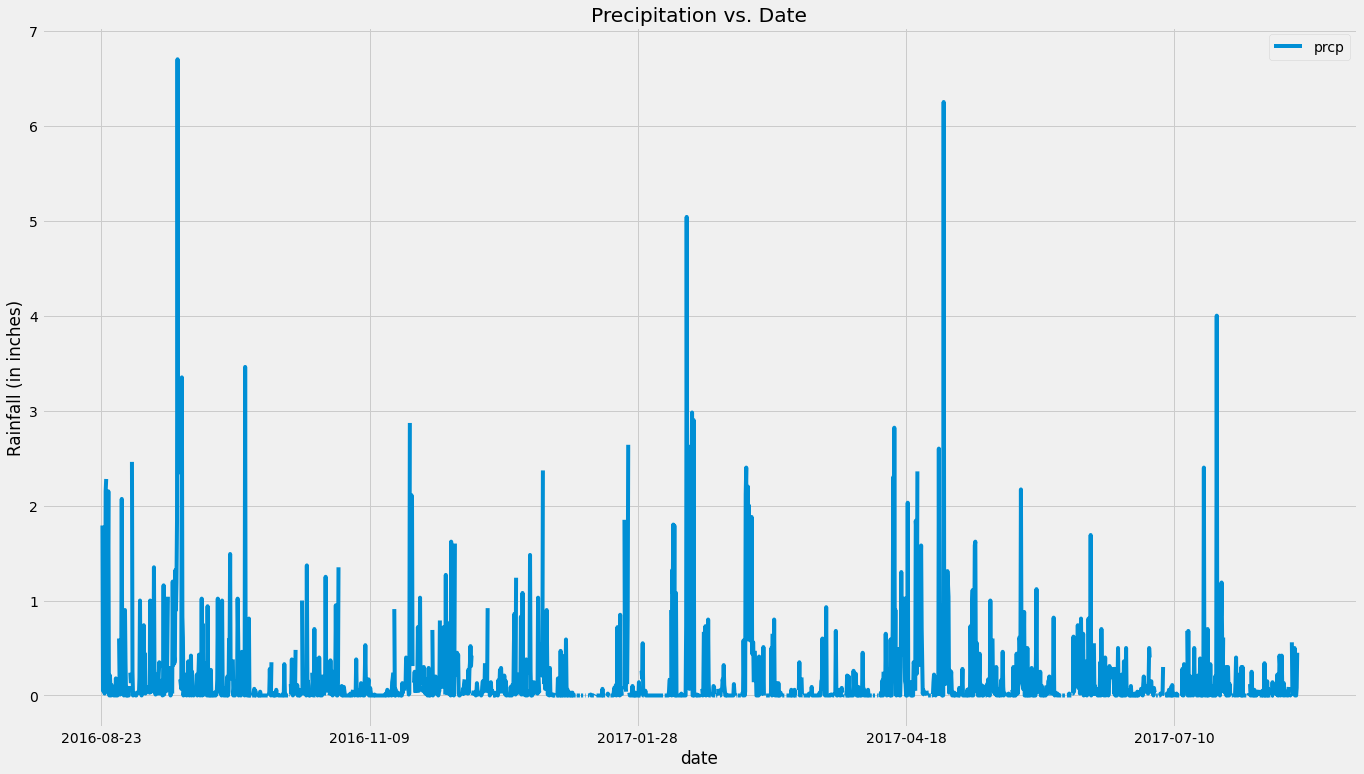

In [86]:
# Use Pandas Plotting with Matplotlib to plot the data
fig = rain_1617_df.plot(figsize=(21, 12))
fig.set_ylabel("Rainfall (in inches)")
fig.set_title("Precipitation vs. Date")
plt.show(fig)

In [45]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rain_1617_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [47]:
# Design a query to calculate the total number stations in the dataset
total_stations= session.query(station_ref.station).group_by(station_ref.station).count()
total_stations

9

In [54]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations= session.query(measure_ref.station, func.count(measure_ref.id)).group_by(measure_ref.
                                                 station).order_by(func.count(measure_ref.id).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [87]:
active_stations[0][0]

'USC00519281'

In [88]:
measure_df.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [63]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active= active_stations[0][0]
lowest= session.query(func.min(measure_ref.tobs)).filter(measure_ref.station == most_active).all()[0][0]
average= session.query(func.avg(measure_ref.tobs)).filter(measure_ref.station == most_active).all()[0][0]
highest= session.query(func.max(measure_ref.tobs)).filter(measure_ref.station == most_active).all()[0][0]

print(f'Station {most_active} is the most active of the stations over the past year. The lowest temperature experienced was {lowest} degrees, and the highest temperature experienced was {highest}. On average, you can expect a temperature of {average} in this area.')

Station USC00519281 is the most active of the stations over the past year. The lowest temperature experienced was 54.0 degrees, and the highest temperature experienced was 85.0. On average, you can expect a temperature of 71.66378066378067 in this area.


In [69]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_year= session.query(measure_ref.date, measure_ref.tobs).filter(measure_ref.station == 
                                                    most_active).filter(measure_ref.date >= (year_before)).all()

# Making into a dataframe
most_df= pd.DataFrame(most_active_year)
most_df.head()

,date,tobs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


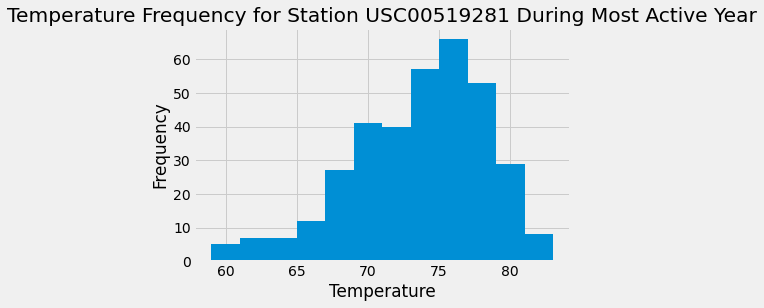

In [80]:
# Histogram
plt.hist(most_df["tobs"], bins=12)
plt.xlabel("Temperature (in Fahrenheit)")
plt.ylabel("Frequency")
plt.title(f"Temperature Frequency for Station USC00519281 During Most Active Year")
plt.show()

# Close session

In [17]:
# Close Session
session.close()

NameError: name 'session' is not defined